In [2]:

import numpy as np
import pandas as pd


train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')
#sample_submission = pd.read_csv(input_path / 'sample_submission.csv')

train_df.shape, test_df.shape

((230130, 5), (98550, 4))

In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index('date')

test_df['date'] = pd.to_datetime(test_df['date'])
test_df = test_df.set_index('date')

# 📊 Datatypes and missing

In [4]:
# Get dtypes for train and test
train_df_dtypes = pd.DataFrame(train_df.dtypes)
test_df_dtypes = pd.DataFrame(test_df.dtypes)

# Combined dtypes for inspection
dtypes_combined = pd.concat([train_df_dtypes, test_df_dtypes], axis=1)
dtypes_combined

,0,0
country,object,object
store,object,object
product,object,object
num_sold,float64,NaN


In [5]:
train_missings_df = train_df.groupby(['country','store','product'])['num_sold'].count().rename("n_records").reset_index()
train_missings_df['n_records'] = np.abs(train_missings_df['n_records'] - 2557)
train_missings_df = train_missings_df.loc[train_missings_df.n_records > 0]
train_missings_df

,country,store,product,n_records
0,Canada,Discount Stickers,Holographic Goose,2557
3,Canada,Discount Stickers,Kerneler,1
5,Canada,Premium Sticker Mart,Holographic Goose,380
10,Canada,Stickers for Less,Holographic Goose,1308
45,Kenya,Discount Stickers,Holographic Goose,2557
48,Kenya,Discount Stickers,Kerneler,63
49,Kenya,Discount Stickers,Kerneler Dark Mode,1
50,Kenya,Premium Sticker Mart,Holographic Goose,646
55,Kenya,Stickers for Less,Holographic Goose,1358


We can also check if there is a pattern to be found in the data that is missing. Lets plot the missings on the total number of sales for each combination.

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(5, 2, figsize=(18, 12))
ax = ax.flatten()

for i, (combi, df) in enumerate(train_missings_df.groupby(['country','store','product'])):
    country, store, product = combi

    combi_with_missings = train_df.loc[
        (train_df.country==country) & (train_df.store==store) & (train_df['product']==product)
    ]

    combi_missing_vals = combi_with_missings.loc[
        combi_with_missings.num_sold.isna()
    ]

    sns.lineplot(combi_with_missings, ax=ax[i])
    ax[i].set_xlim(train_df.index.min(), train_df.index.max())

    for missing_val in combi_missing_vals.index:
        ax[i].axvline(missing_val, color='green', linestyle='-', linewidth=1, alpha=0.2)

plt.tight_layout()

Error in callback <function _draw_all_if_interactive at 0x7c5cb5df9750> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7c5cb5df89d0> (for post_execute):


KeyboardInterrupt: 

We now know that we have varying degrees of missing information in the training data. For the test data we are simply not sure. For each day (1095 = 365 days * 3 years) in the test data we have a record for the missing combination. We should handle this with care. Possible scenarios: drop rows with missing, impute nan with zero or impute with sales ratio between stores.

Lets further inspect the products sold by calculating the average number of product solds in each store. We see that on average The Premium Sticker Mart sells the most procucts, followed by Stickers for Less and Discount Stickers.

In [10]:
country_store_sales = train_df.groupby(['country', 'store', 'product']).num_sold.mean().unstack(level='store')
country_store_sales

store                         Discount Stickers  Premium Sticker Mart  \
country   product                                                       
Canada    Holographic Goose                 NaN            248.382177   
          Kaggle                     715.652718           1712.174032   
          Kaggle Tiers               592.579194           1417.701995   
          Kerneler                   323.602113            773.023465   
          Kerneler Dark Mode         377.781776            904.393430   
Finland   Holographic Goose           98.001564            235.260461   
          Kaggle                     703.688698           1684.023074   
          Kaggle Tiers               581.462652           1388.125147   
          Kerneler                   317.497849            758.843176   
          Kerneler Dark Mode         372.158389            890.979664   
Italy     Holographic Goose           70.846304            170.382871   
          Kaggle                     509.840438           1219.964411   
          Kaggle Tiers               421.778256           1008.123582   
          Kerneler                   230.076261            550.736801   
          Kerneler Dark Mode         268.933516            644.371529   
Kenya     Holographic Goose                 NaN              5.941915   
          Kaggle                      17.160735             41.732499   
          Kaggle Tiers                14.109894             34.460696   
          Kerneler                     7.578990             18.615565   
          Kerneler Dark Mode           8.824335             21.827141   
Norway    Holographic Goose          186.725851            447.119671   
          Kaggle                    1339.298005           3197.896754   
          Kaggle Tiers              1105.479077           2642.728197   
          Kerneler                   603.490418           1441.943684   
          Kerneler Dark Mode         707.368792           1689.502151   
Singapore Holographic Goose          113.131795            271.564333   
          Kaggle                     814.008995           1937.877591   
          Kaggle Tiers               671.281971           1604.389128   
          Kerneler                   366.472038            875.784122   
          Kerneler Dark Mode         428.336723           1024.878373   

store                         Stickers for Less  
country   product                                
Canada    Holographic Goose          228.816653  
          Kaggle                    1449.021510  
          Kaggle Tiers              1198.617912  
          Kerneler                   654.836918  
          Kerneler Dark Mode         763.250293  
Finland   Holographic Goose          198.955808  
          Kaggle                    1424.984357  
          Kaggle Tiers              1175.055925  
          Kerneler                   641.964803  
          Kerneler Dark Mode         752.648025  
Italy     Holographic Goose          144.018381  
          Kaggle                    1031.843958  
          Kaggle Tiers               852.334767  
          Kerneler                   465.649980  
          Kerneler Dark Mode         544.719984  
Kenya     Holographic Goose            5.470392  
          Kaggle                      35.286273  
          Kaggle Tiers                29.040282  
          Kerneler                    15.646461  
          Kerneler Dark Mode          18.412984  
Norway    Holographic Goose          378.892061  
          Kaggle                    2705.404380  
          Kaggle Tiers              2235.983183  
          Kerneler                  1223.681658  
          Kerneler Dark Mode        1432.892452  
Singapore Holographic Goose          229.463043  
          Kaggle                    1643.064138  
          Kaggle Tiers              1356.942120  
          Kerneler                   741.365663  
          Kerneler Dark Mode         867.225655

## Percentage of sales

In [11]:
store_pct = pd.concat([
    country_store_sales['Discount Stickers'] / np.sum(country_store_sales, axis=1),
    country_store_sales['Premium Sticker Mart'] / np.sum(country_store_sales, axis=1),
    country_store_sales['Stickers for Less'] / np.sum(country_store_sales, axis=1)
], axis=1).rename(
    columns={
        0: 'Discount Stickers',
        1: 'Premium Sticker Mart',
        2: 'Stickers for Less'
    }
)

store_pct

Discount Stickers  Premium Sticker Mart  \
country   product                                                       
Canada    Holographic Goose                 NaN              0.520500   
          Kaggle                       0.184597              0.441641   
          Kaggle Tiers                 0.184667              0.441803   
          Kerneler                     0.184761              0.441359   
          Kerneler Dark Mode           0.184696              0.442154   
Finland   Holographic Goose            0.184138              0.442038   
          Kaggle                       0.184565              0.441688   
          Kaggle Tiers                 0.184906              0.441425   
          Kerneler                     0.184774              0.441623   
          Kerneler Dark Mode           0.184622              0.442001   
Italy     Holographic Goose            0.183898              0.442269   
          Kaggle                       0.184615              0.441752   
          Kaggle Tiers                 0.184809              0.441726   
          Kerneler                     0.184583              0.441840   
          Kerneler Dark Mode           0.184451              0.441948   
Kenya     Holographic Goose                 NaN              0.520659   
          Kaggle                       0.182213              0.443117   
          Kaggle Tiers                 0.181803              0.444019   
          Kerneler                     0.181138              0.444912   
          Kerneler Dark Mode           0.179852              0.444867   
Norway    Holographic Goose            0.184377              0.441496   
          Kaggle                       0.184920              0.441540   
          Kaggle Tiers                 0.184733              0.441618   
          Kerneler                     0.184604              0.441081   
          Kerneler Dark Mode           0.184703              0.441151   
Singapore Holographic Goose            0.184206              0.442173   
          Kaggle                       0.185215              0.440933   
          Kaggle Tiers                 0.184793              0.441663   
          Kerneler                     0.184749              0.441508   
          Kerneler Dark Mode           0.184593              0.441674   

                              Stickers for Less  
country   product                                
Canada    Holographic Goose            0.479500  
          Kaggle                       0.373763  
          Kaggle Tiers                 0.373529  
          Kerneler                     0.373880  
          Kerneler Dark Mode           0.373150  
Finland   Holographic Goose            0.373824  
          Kaggle                       0.373747  
          Kaggle Tiers                 0.373669  
          Kerneler                     0.373603  
          Kerneler Dark Mode           0.373377  
Italy     Holographic Goose            0.373833  
          Kaggle                       0.373633  
          Kaggle Tiers                 0.373465  
          Kerneler                     0.373577  
          Kerneler Dark Mode           0.373601  
Kenya     Holographic Goose            0.479341  
          Kaggle                       0.374670  
          Kaggle Tiers                 0.374178  
          Kerneler                     0.373950  
          Kerneler Dark Mode           0.375281  
Norway    Holographic Goose            0.374127  
          Kaggle                       0.373541  
          Kaggle Tiers                 0.373648  
          Kerneler                     0.374316  
          Kerneler Dark Mode           0.374146  
Singapore Holographic Goose            0.373621  
          Kaggle                       0.373853  
          Kaggle Tiers                 0.373544  
          Kerneler                     0.373743  
          Kerneler Dark Mode           0.373733

Thats interesting. The percentage of all the products sold between the different shops and countries is almost identitcal, except ofcourse for the shops in Canada and Kenya where Holographic Goose data is missing. However, if we make the assumption that the missing values are errornuous, we can probably decompose the sales for these products using the total number of sales and the percentages.

## Ratio of Sales

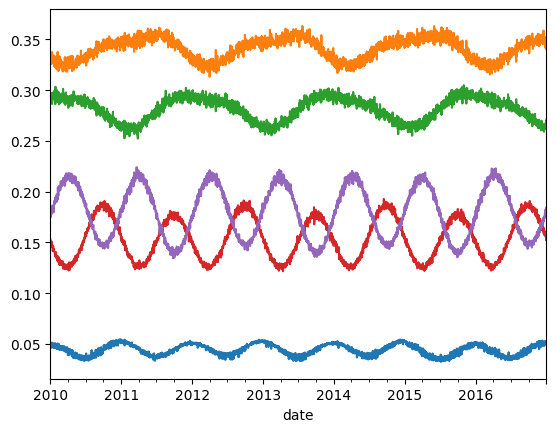

In [12]:
sold_column = train_df.groupby([train_df.index, 'product']).num_sold.sum().reset_index().pivot(index="date", columns='product', values='num_sold')

for product in np.unique(train_df['product']):
    sold_column.divide(sold_column.sum(axis=1), axis=0)[product].plot()

In [13]:
 country_store_sales_ratio = pd.concat([
     country_store_sales['Premium Sticker Mart'] / country_store_sales['Discount Stickers'],
     country_store_sales['Stickers for Less'] / country_store_sales['Discount Stickers'],
     country_store_sales['Premium Sticker Mart'] / country_store_sales['Stickers for Less']
 ], axis=1).rename(
     columns={
         0: 'ratio_premium_discount',
         1: 'ratio_less_discount',
         2: 'ratio_premium_less'
     }
 )

country_store_sales_ratio

ratio_premium_discount  ratio_less_discount  \
country   product                                                           
Canada    Holographic Goose                      NaN                  NaN   
          Kaggle                            2.392465             2.024755   
          Kaggle Tiers                      2.392426             2.022713   
          Kerneler                          2.388808             2.023587   
          Kerneler Dark Mode                2.393957             2.020347   
Finland   Holographic Goose                 2.400579             2.030129   
          Kaggle                            2.393136             2.025021   
          Kaggle Tiers                      2.387299             2.020862   
          Kerneler                          2.390073             2.021950   
          Kerneler Dark Mode                2.394087             2.022386   
Italy     Holographic Goose                 2.404965             2.032828   
          Kaggle                            2.392836             2.023857   
          Kaggle Tiers                      2.390174             2.020812   
          Kerneler                          2.393714             2.023894   
          Kerneler Dark Mode                2.396025             2.025482   
Kenya     Holographic Goose                      NaN                  NaN   
          Kaggle                            2.431860             2.056222   
          Kaggle Tiers                      2.442307             2.058150   
          Kerneler                          2.456207             2.064452   
          Kerneler Dark Mode                2.473517             2.086614   
Norway    Holographic Goose                 2.394525             2.029136   
          Kaggle                            2.387741             2.020017   
          Kaggle Tiers                      2.390573             2.022637   
          Kerneler                          2.389340             2.027674   
          Kerneler Dark Mode                2.388432             2.025665   
Singapore Holographic Goose                 2.400425             2.028281   
          Kaggle                            2.380659             2.018484   
          Kaggle Tiers                      2.390038             2.021419   
          Kerneler                          2.389771             2.022980   
          Kerneler Dark Mode                2.392693             2.024635   

                              ratio_premium_less  
country   product                                 
Canada    Holographic Goose             1.085507  
          Kaggle                        1.181607  
          Kaggle Tiers                  1.182781  
          Kerneler                      1.180482  
          Kerneler Dark Mode            1.184924  
Finland   Holographic Goose             1.182476  
          Kaggle                        1.181784  
          Kaggle Tiers                  1.181327  
          Kerneler                      1.182064  
          Kerneler Dark Mode            1.183793  
Italy     Holographic Goose             1.183063  
          Kaggle                        1.182315  
          Kaggle Tiers                  1.182779  
          Kerneler                      1.182727  
          Kerneler Dark Mode            1.182941  
Kenya     Holographic Goose             1.086196  
          Kaggle                        1.182684  
          Kaggle Tiers                  1.186652  
          Kerneler                      1.189762  
          Kerneler Dark Mode            1.185421  
Norway    Holographic Goose             1.180071  
          Kaggle                        1.182040  
          Kaggle Tiers                  1.181909  
          Kerneler                      1.178365  
          Kerneler Dark Mode            1.179085  
Singapore Holographic Goose             1.183477  
          Kaggle                        1.179429  
          Kaggle Tiers                  1.182356  
          Kerneler                 

The ratio of sales between all the shops is also almost identical for each combination and is always around 2.39:2.02:1.18. This means that the Premium Sticker Mart sells 2.39 times more than Discount Stickers, Stickers for Less sells 2.02 times more than Discount stickers and Premium Sticker Mart sells 1.18 times more than Stickers for Less. Keep in mind that there are some fluctuations in the ratios between some combinations. That is something we could inspect further.

# 🤖 Sales between products

Lets start by grouping every combination of country, store, product with year or month. This way we can get some insights in to possible seasonal effects.

In [14]:
import itertools

pd.options.display.max_rows=10

product_ratio_year = train_df.groupby(['country','store','product', train_df.index.year])['num_sold'].mean().unstack(level='product')
product_ratio_month = train_df.groupby(['country','store','product', train_df.index.month])['num_sold'].mean().unstack(level='product')

ratio_columns = []

for p1, p2 in itertools.combinations(product_ratio_year.columns, 2):
    column_name = f"{p1}/{p2}"
    ratio_columns.append(column_name)
    product_ratio_year[column_name] = product_ratio_year[p1] / product_ratio_year[p2]
    product_ratio_month[column_name] = product_ratio_month[p1] / product_ratio_month[p2]

product_ratio_year = product_ratio_year[ratio_columns]
product_ratio_month = product_ratio_month[ratio_columns]

In [15]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ratios(ratio_df):

    n_cols = 2
    n_rows = math.ceil(len(ratio_columns) / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18,12))
    ax = ax.flatten()
    
    for i, ratio_col in enumerate(ratio_columns):
    
        sns.lineplot(
            ratio_df[ratio_col].reset_index(), x='date', y=ratio_col, hue='store', ax=ax[i]
        )
    
    plt.tight_layout()

## Ratio of sales by year

Plotting the ratios of all the 10 unique two-product combinations shows that there aren't a lot of differences betweens the different stores in each country in each year. The trend in each store follows that of the others. If the ratio goes up in one store, the ratio in the other store goes also up. If the ratio goes down in one store, the ratio in the other stores also goes down. If stable, the other stores are also stable.

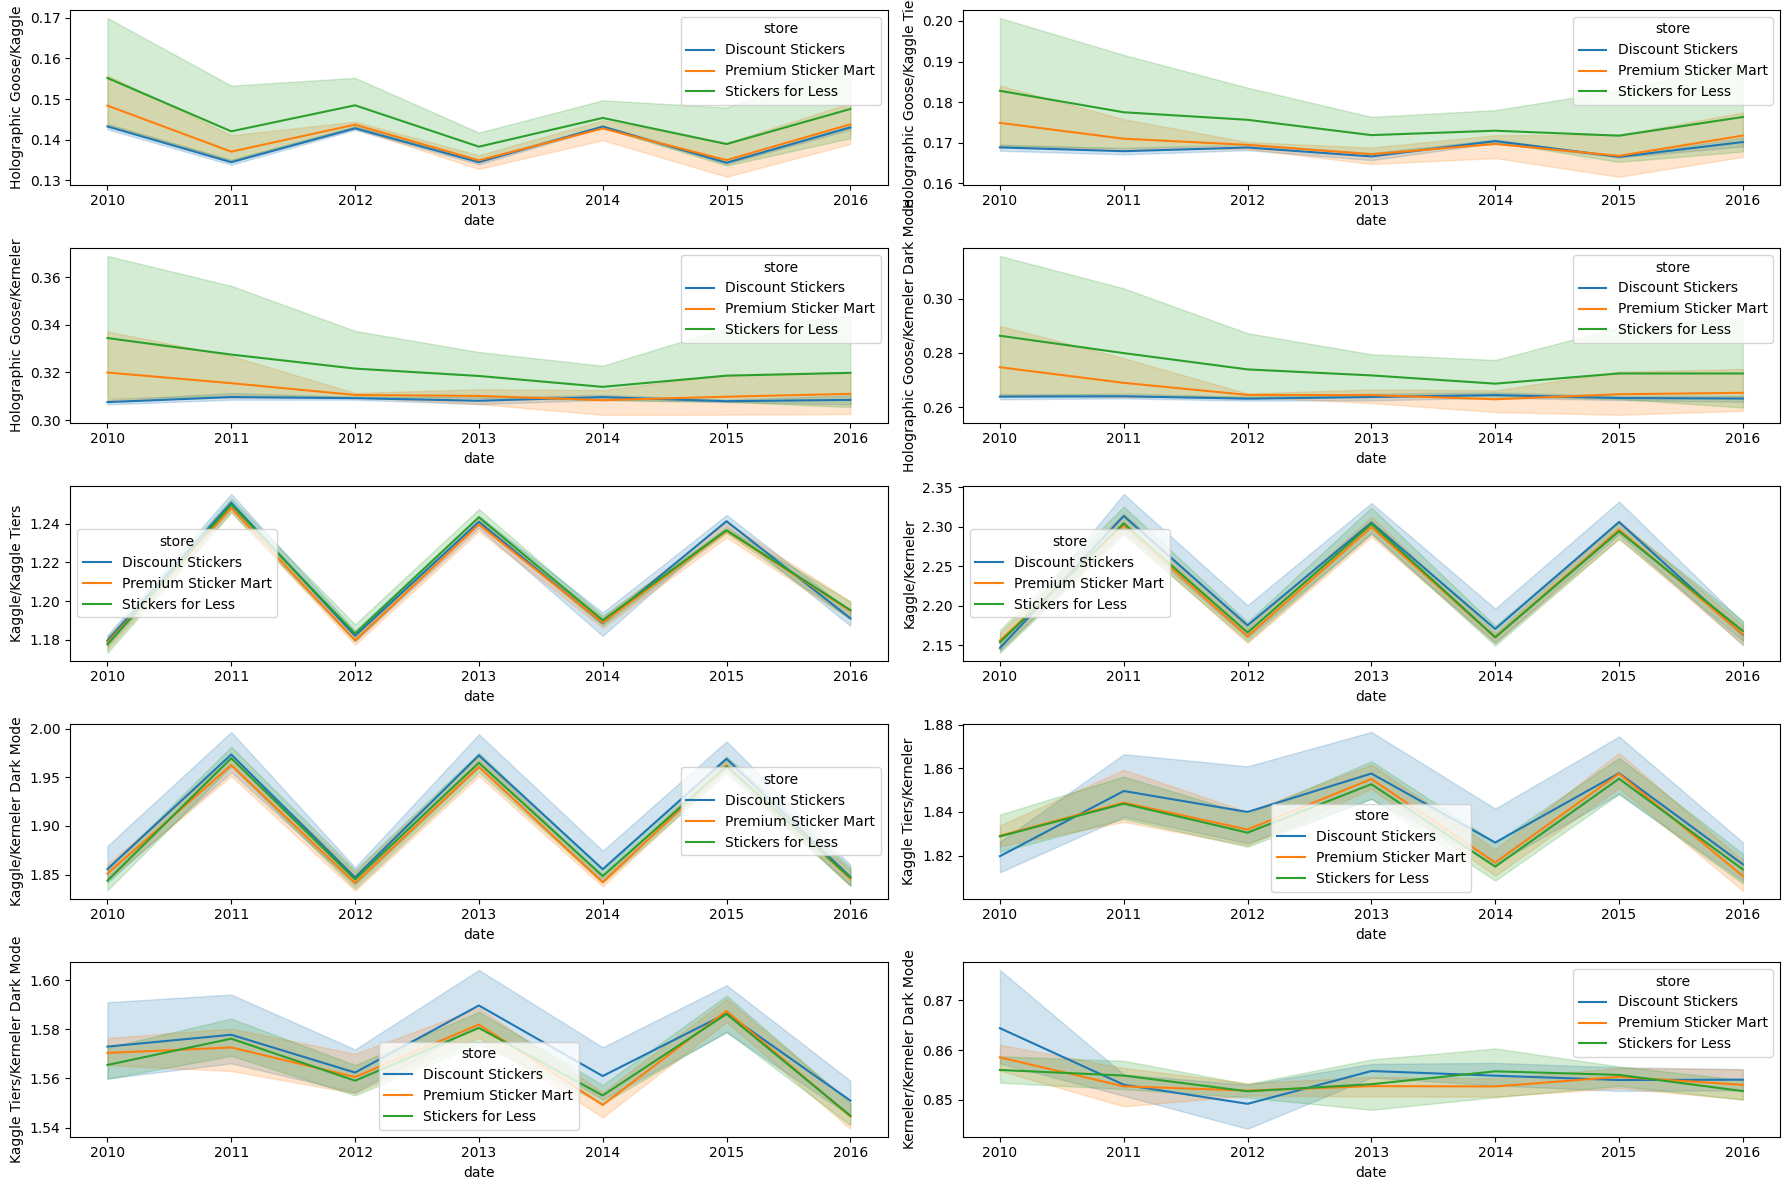

In [16]:
plot_ratios(product_ratio_year)

## Ratio of sales by month

The ratios of all product combinations by month shows that there are some strong seasonal effects for each combination. One interesting thing is that the combination Kaggle/Kaggle Tiers shows a slightly upward moving linear trend. Other products show more sales during the first months of the year while others are sold more in the last months of the year.

In [ ]:
plot_ratios(product_ratio_month)

In [17]:
no_goose_df = train_df.loc[
    ~(((train_df.country == 'Canada') & (train_df.store=='Discount Stickers') & (train_df['product']=='Holographic Goose')) |
    ((train_df.country == 'Kenya') & (train_df.store=='Discount Stickers') & (train_df['product']=='Holographic Goose')))
]

# 📊 Histograms

In [ ]:
plt.figure(figsize=(18,72))
for i, (combi, df) in enumerate(no_goose_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(30, 3, i+1, ymargin=0.5)
    ax.hist(df.num_sold, bins=50, color='pink')
    ax.set_title(combi)
plt.tight_layout(h_pad=3.0)
plt.show()

# 📈Time series

Plotting the number of sold products for each combination of country, store and product as a timeseries shows that we can discern a basically three different patterns. Which we also saw more clearly in the plots we created for the ratios between two products in each shop. The basic idea here is that we can create groups between products following the same pattern.

* Kaggle and Kaggle Tiers follow the same cyclical pattern with sales up one year and sales down the other year (2 year period). Sales for Kaggle are slightly increasing during the year but the pattern remains the same. Thats why we saw the linear line in the previous ratio plots.
* Kerneler and Kerneler Dark Mode also have cyclical pattern where Kerneler Dark Mode sales peak in the first part of the year and Kerneler sales peak in the second part of the year.
* Holographic Goose sales peak around the end of the year and sales are low during summer.

These differences mean we have to model seasonal effects which depend on the product.

In [18]:
plt.figure(figsize=(18,82))
for i, (combi, df) in enumerate(no_goose_df.groupby(['country', 'store', 'product'])):
    ax = plt.subplot(30, 3, i+1, ymargin=0.5)
    sns.lineplot(df, x='date', y='num_sold')
    ax.set_title(combi)
plt.tight_layout(h_pad=3.0)
plt.show()

KeyboardInterrupt: 

The seasonal patterns are more clearly seen when plotting the percentages of sales over time for each dimension (country, store or product). We start by plotting the percentage of sales for the dimension country. Its seen that over time the percentage of sales per country is rather stable.

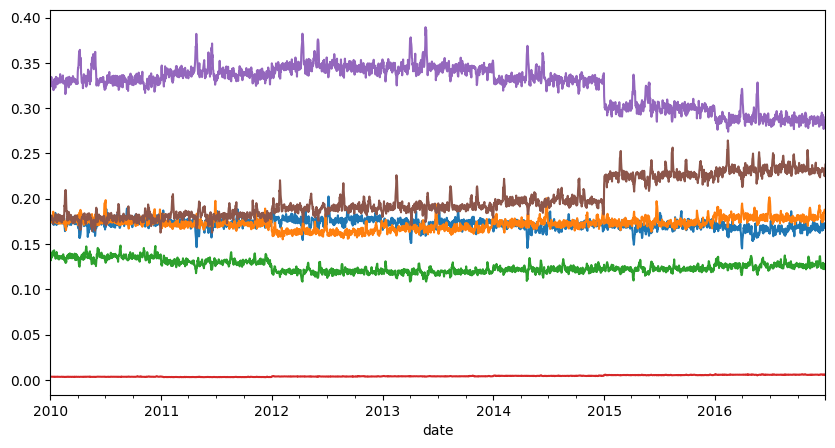

In [19]:
sold_column = train_df.groupby([train_df.index, 'country']).num_sold.sum().reset_index().pivot(index="date", columns='country', values='num_sold')

fig, ax = plt.subplots(figsize=(10,5))

for product in np.unique(train_df['country']):
    sold_column.divide(sold_column.sum(axis=1), axis=0)[product].plot()

Lets continu by inspecting the percentage of sales over time for the stores. We see that the percentage of sales for all the stores is constant.

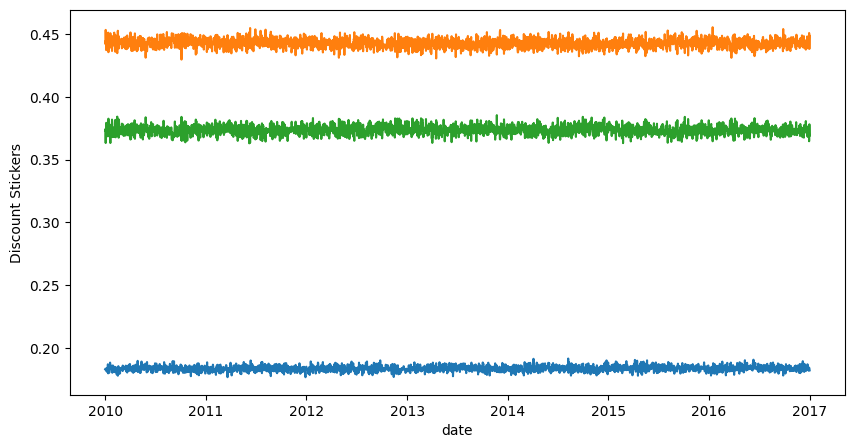

In [20]:
sold_column = train_df.groupby([train_df.index, 'store']).num_sold.sum().reset_index().pivot(index="date", columns='store', values='num_sold')

fig, ax = plt.subplots(figsize=(10,5))

for product in np.unique(train_df['store']):
    sns.lineplot(sold_column.divide(sold_column.sum(axis=1), axis=0)[product])

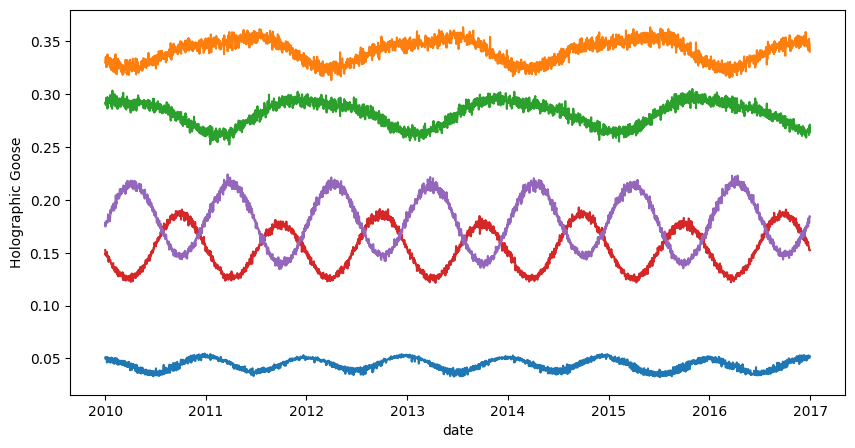

In [21]:
sold_column = train_df.groupby([train_df.index, 'product']).num_sold.sum().reset_index().pivot(index="date", columns='product', values='num_sold')

fig, ax = plt.subplots(figsize=(10,5))

for product in np.unique(train_df['product']):
    sns.lineplot(sold_column.divide(sold_column.sum(axis=1), axis=0)[product])

The only dimension that isn't really stable is product. While country and store show a constant line, we clearly see here that products follow a cyclical trend during the year. Lets dig deeper by inspecting for each of the products what the average sales are by week of the year.

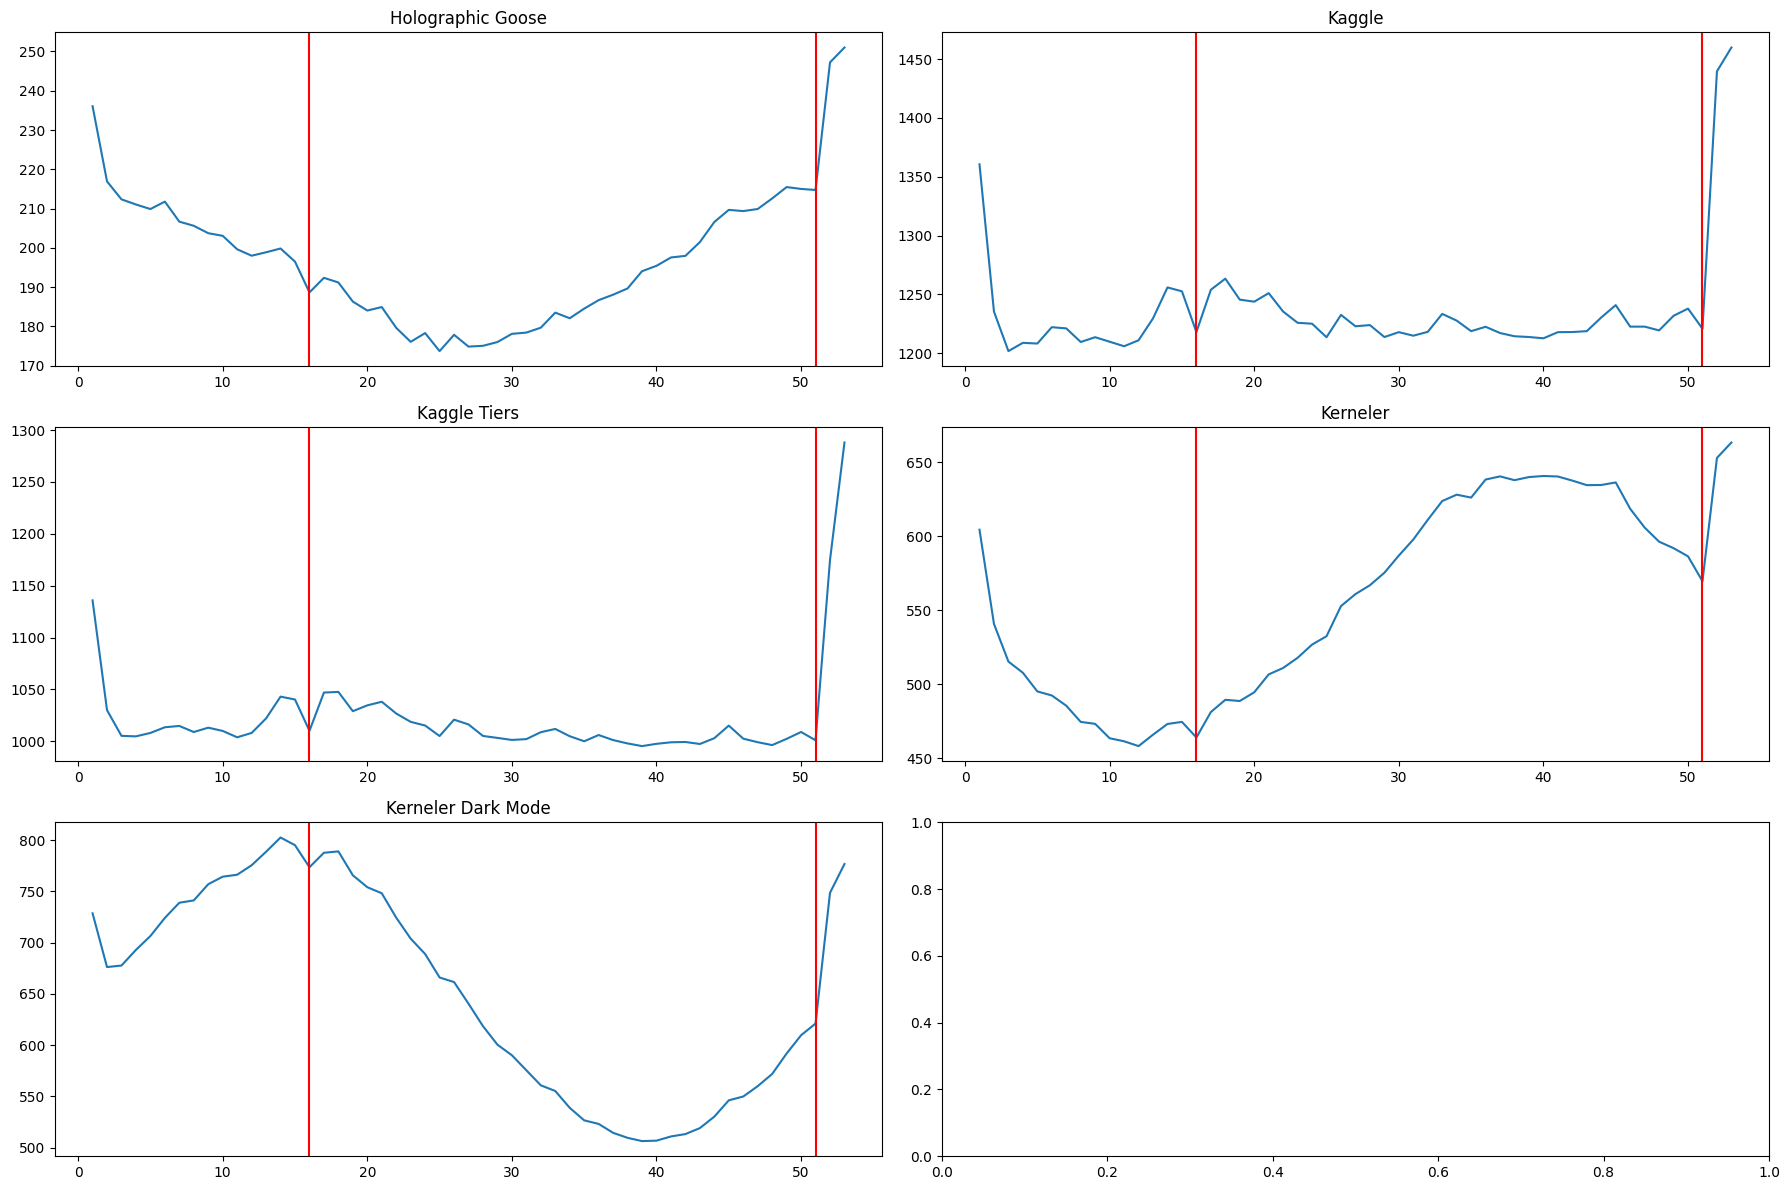

In [22]:
fig, ax = plt.subplots(3,2,figsize=(18, 12))
ax = ax.flatten()

for i, product in enumerate(np.unique(train_df['product'])):
    weekly_product = train_df.loc[train_df['product']==product].resample('W')['num_sold'].mean().to_frame()
    weekly_product = weekly_product.groupby(weekly_product.index.isocalendar().week)['num_sold'].mean()
    ax[i].plot(weekly_product)
    ax[i].set_title(product)
    ax[i].axvline(16, color='red')
    ax[i].axvline(51, color='red')
plt.tight_layout()

Interesting, although patterns differ we see that sales peak at the start and end of the year. Furthere more there are some overlapping dips, e.g. around week 16. If we look on a weekly basis we see that sales from monday till thursday are really stable. On friday and thursday the sales are ramping up and peaking on sunday.

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(18, 12))
ax = ax.flatten()

for i, product in enumerate(np.unique(train_df['product'])):
    weekday_product = train_df.loc[train_df['product']==product].resample('D')['num_sold'].mean().to_frame()
    weekday_product = weekday_product.groupby(weekday_product.index.dayofweek)['num_sold'].mean()
    ax[i].plot(weekday_product)
    ax[i].set_title(product)
    ax[i].axvline(3, color='orange')
    ax[i].axvline(5, color='orange')
    ax[i].axvline(6, color='purple')
plt.tight_layout()

# GDP Per Country

In [23]:
from sklearn.preprocessing import RobustScaler

def decompose(train, c):
    df = train_df.groupby(['date', c])['num_sold'].sum().reset_index()
    df['num_sold_scaled'] = df.groupby('date')['num_sold'].transform(lambda x: RobustScaler().fit_transform(x.values.reshape(-1,1)).flatten())
    for i,m in enumerate(np.sort(df[c].unique())):
        mask = df[c]==m
        ax[i].plot(df[mask]['date'], df[mask]['num_sold_scaled'], label=m)
        ax[i].legend(bbox_to_anchor=(1,1))
    plt.tight_layout()

In [24]:
gdp = list()
years = np.arange(2010, 2017).astype(str)
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']

for c in np.unique(train_df.country):
    gdp_c = gdp_per_capita[gdp_per_capita['Country Name']==c][years].values.ravel()
    gdp.append(gdp_c)

gdp = pd.DataFrame(
    RobustScaler().fit_transform(np.array(gdp)), index=alpha3s, columns=years
)

gdp

,2010,2011,2012,2013,2014,2015,2016
CAN,0.080494,0.048567,0.149263,0.082291,0.020821,0.021060,-0.037091
FIN,-0.043821,-0.048567,-0.149263,-0.082291,-0.020821,-0.021060,0.037091
ITA,-1.223625,-1.110587,-0.911322,-0.937577,-0.903198,-0.672727,-0.611674
KEN,-5.162550,-4.302159,-2.945226,-2.978790,-2.941635,-2.165872,-2.097365
NOR,4.607264,4.164363,3.090691,3.083554,2.777938,1.617693,1.384478
SGP,0.043821,0.190369,0.322503,0.340896,0.416255,0.646566,0.696933


In [25]:
df = train_df.reset_index()[['date', 'country']]
df['alpha3'] = df['country'].map(dict(zip(np.sort(np.unique(df['country'])), alpha3s)))
df['year'] = df['date'].dt.year.astype(str)
df['gdp'] = df.apply(lambda s: gdp.loc[s['alpha3'], s['year']], axis=1)

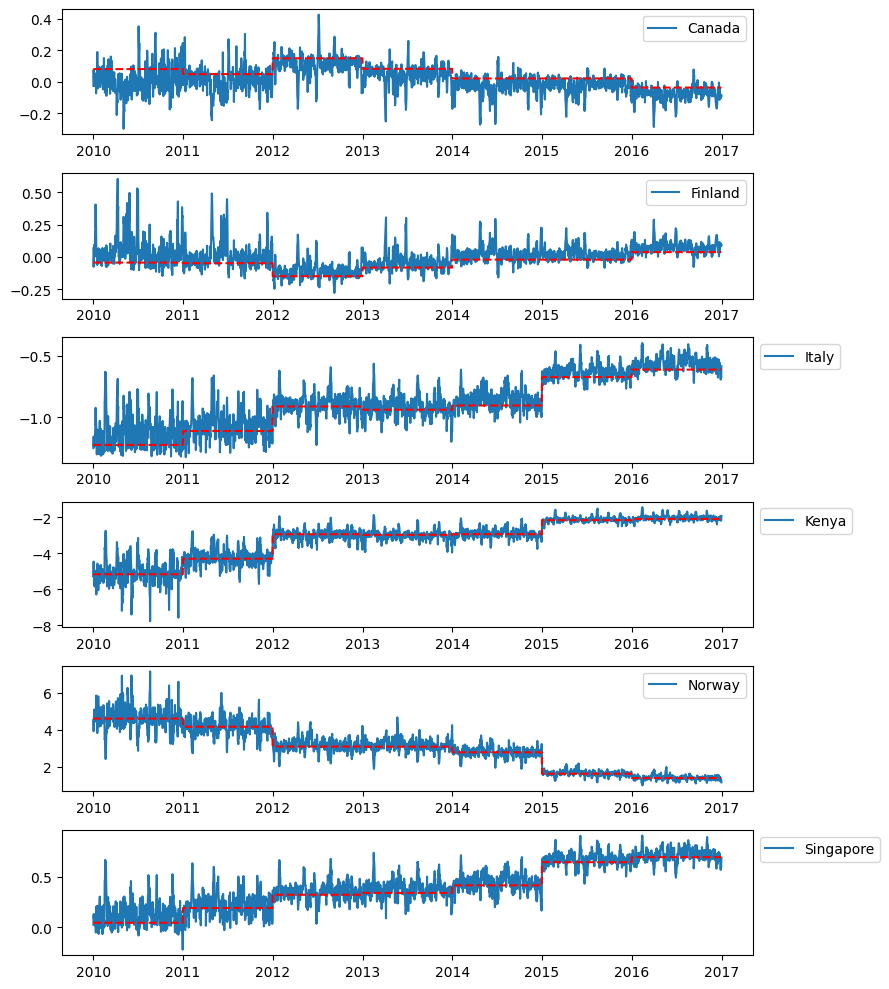

In [26]:
fig, ax = plt.subplots(6, 1, figsize=(9, 10))
decompose(train_df, 'country')
for i, country in enumerate(df['country'].unique()):
    mask = df['country']==country
    ax[i].plot(df[mask]['date'], df[mask]['gdp'], 'k--', color='red')

In [27]:
df = train_df.reset_index().groupby(['date','country'])[['num_sold']].sum().reset_index().join(
    train_df.reset_index().groupby('date')[['num_sold']].sum(), on='date',rsuffix='_global'
)

df['fractions'] = df['num_sold'] / df['num_sold_global']

<Axes: xlabel='date', ylabel='num_sold'>

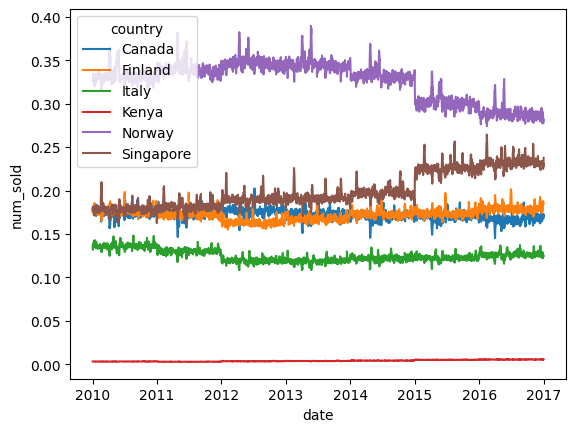

In [28]:
import seaborn as sns

ratio_by_country = (train_df.groupby([train_df.index, train_df.country])['num_sold'].sum() / train_df.groupby(train_df.index)['num_sold'].sum()).reset_index()

sns.lineplot(ratio_by_country, x='date', y='num_sold', hue='country')

# 💸 Impute missings based on GDP

In [29]:
# List all the unique countries in the training data
countries = np.unique(train_df.country)

# List all the years in the training and testing data
gdp_years = list(np.arange(2010,2020).astype('str'))

# Select only the relevant countries
gdp_per_capita = gdp_per_capita.loc[gdp_per_capita['Country Name'].isin(train_df.country.unique())]

# Select only the country name column and relevant years
gdp_per_capita = gdp_per_capita[['Country Name'] + gdp_years].set_index('Country Name')

# Calculate the ratio by dividing on the sum of the column
gdp_ratio_years = gdp_per_capita / gdp_per_capita.sum(axis=0)

# Unstack so we can easily join back on the training data
gdp_ratio_years = gdp_ratio_years.unstack().reset_index().rename(
    columns={'level_0': 'year','Country Name':'country', 0: 'gdp_ratio'}
)

gdp_total_years = gdp_per_capita.unstack().reset_index().rename(
    columns={'level_0':'year','Country Name': 'country', 0: 'gdp'}
)

gdp_pivot = gdp_total_years.pivot(index='year', columns='country', values='gdp')

In [30]:
train_df_imputed = train_df.copy().reset_index()
train_df_imputed['year'] = train_df_imputed['date'].dt.year.astype('str')
train_df_imputed

,date,country,store,product,num_sold,year
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010
...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016
230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016


In [31]:
def impute_missing_multiply_by_gdp_ratio(impute_df, gdp_df, missings_df):
    """
    Impute missings values based on the ratio of GDP per country. It 
    handles both complete missing time series and partly missing data
    in a time series. 

    Args:
        impute_df: The dataframe on which we want to impute data.
        gdp_df: The dataframe with the GDP data per country.
        missings_df: The dataframe with all the missing combinations.

    Returns:
        A new dataframe with 
    """

    df = impute_df.copy()

    for row in missings_df.itertuples():
        for year in np.unique(df['year']):
            # Get missing timestamp for each combination of missing and year
            missing_ts = df.loc[
                (df['country']==row.country) & 
                (df['store']==row.store) &
                (df['product']==row.product) &
                (df['year']==year) &
                (df['num_sold'].isna()),
                'date'
            ]

            # Get ratio for current Country
            current_ratio = gdp_df.loc[
                (gdp_df['year']==year) & (gdp_df['country']==row.country), 'gdp_ratio'
            ].values[0]

            # We always use Norway as the baseline. Also try other countries to see impact, but is should not matter.
            target_ratio = gdp_df.loc[
                (gdp_df['year']==year) & (gdp_df['country']=='Norway'), 'gdp_ratio'
            ].values[0]
            
            multiply_ratio = current_ratio / target_ratio

            shape_missings = missing_ts.shape[0]

            if shape_missings > 0:

                print(f'Imputing combination: {row.country} - {row.store} - {row.product} - {year} - {shape_missings} records')
                
                df.loc[
                    (df['country']==row.country) & 
                    (df['store']==row.store) &
                    (df['product']==row.product) &
                    (df['date'].isin(missing_ts)),
                    'num_sold'
                ] = np.round(
                    df.loc[
                    (df['country']=='Norway') & 
                    (df['store']==row.store) &
                    (df['product']==row.product) &
                    (df['date'].isin(missing_ts)),
                    'num_sold'
                ] * multiply_ratio).values

    return df

train_df_imputed = impute_missing_multiply_by_gdp_ratio(train_df_imputed, gdp_ratio_years, train_missings_df)

Imputing combination: Canada - Discount Stickers - Holographic Goose - 2010 - 365 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2011 - 365 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2012 - 366 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2013 - 365 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2014 - 365 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2015 - 365 records
Imputing combination: Canada - Discount Stickers - Holographic Goose - 2016 - 366 records
Imputing combination: Canada - Discount Stickers - Kerneler - 2016 - 1 records
Imputing combination: Canada - Premium Sticker Mart - Holographic Goose - 2010 - 77 records
Imputing combination: Canada - Premium Sticker Mart - Holographic Goose - 2011 - 3 records
Imputing combination: Canada - Premium Sticker Mart - Holographic Goose - 2012 - 12 records
Imputing combina

# Model

In [32]:
def get_gdp(row):
    return gdp_pivot.loc[str(row.date.year), row.country]

In [33]:
import holidays

def feature_engineering(df, gdp_ratios):
    """
    Create new features for a given dataframe. It is used to create
    a standardized way to create the same features between the training
    and testing data.

    Args:
        df: The dataframe on which we want to create new features

    Returns:
        A new dataframe with the add features.
    """

    new_df = pd.DataFrame({
        'gdp': np.log(df.apply(get_gdp, axis=1)),
        'is_friday': (df.date.dt.weekday == 4).astype('int'),
        'is_saturday': (df.date.dt.weekday == 5).astype('int'),
        'is_sunday': (df.date.dt.weekday == 6).astype('int')
    })

    new_df = pd.concat([new_df, pd.DataFrame({
        f'dec_{d}': (df.date.dt.month == 12) & (df.date.dt.day == d) for d in range(25, 32)
    })], axis=1)

    new_df = pd.concat([new_df, pd.DataFrame({
        f'jan{d}': (df.date.dt.month == 1) & (df.date.dt.day == d) for d in range(1, 12)
    })], axis=1)

    cols_to_drop = ['country','store','product','year','date']

    new_df['year'] = df['date'].dt.year.astype('str')
    day_of_year = df['date'].dt.dayofyear

    # OHE for country
    for country in ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway']:
        country_mask = (df.country == country).astype('int')
        new_df[country] = country_mask

    # OHE for store
    for store in ['Discount Stickers','Premium Sticker Mart']:
        store_mask = (df.store == store).astype('int')
        new_df[store] = store_mask

    # OHE for product
    for product in ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler','Kerneler Dark Mode']:
        product_mask = (df['product'] == product).astype('int')
        new_df[product] = product_mask

    for k in range(1, 3):
        # Seasonal variations for product
        new_df[f'sin_{k}'] = np.sin(day_of_year / 365 * 2 * np.pi)
        new_df[f'cos_{k}'] = np.cos(day_of_year / 365 * 2 * np.pi)
        
        new_df[f'hgs_sin_{k}'] = new_df[f'sin_{k}'] * new_df['Holographic Goose']
        new_df[f'hgs_cos_{k}'] = new_df[f'cos_{k}'] * new_df['Holographic Goose']
        
        new_df[f'kag_sin_{k}'] = new_df[f'sin_{k}'] * new_df['Kaggle']
        new_df[f'kag_cos_{k}'] = new_df[f'cos_{k}'] * new_df['Kaggle']
    
        new_df[f'kgt_sin_{k}'] = new_df[f'sin_{k}'] * new_df['Kaggle Tiers']
        new_df[f'kgt_cos_{k}'] = new_df[f'cos_{k}'] * new_df['Kaggle Tiers']
        
        new_df[f'krn_sin_{k}'] = new_df[f'sin_{k}'] * new_df['Kerneler']
        new_df[f'krn_cos_{k}'] = new_df[f'cos_{k}'] * new_df['Kerneler']
    
        new_df[f'kdm_sin_{k}'] = new_df[f'sin_{k}'] * new_df['Kerneler Dark Mode']
        new_df[f'kdm_cos_{k}'] = new_df[f'cos_{k}'] * new_df['Kerneler Dark Mode']

    alpha2 = dict(zip(np.sort(train_df.country.unique()), ['CA', 'FI', 'IT', 'KE', 'NO', 'SG']))
    h = {c: holidays.country_holidays(a, years=range(2010, 2020)) for c, a in alpha2.items()}
    new_df['is_holiday'] = 0
    for c in alpha2:
        new_df.loc[df.country==c, 'is_holiday'] = df.date.isin(h[c]).astype(int)

    return new_df

In [34]:
# Add date back as normal column and do feature engineering on test
test_df = test_df.reset_index()
test_df = feature_engineering(test_df, gdp_total_years)

# Extract num_sold before feature engineering
num_sold = train_df_imputed['num_sold'].values

# Do feature engineering on the training data
train_df_imputed = feature_engineering(train_df_imputed, gdp_total_years)
train_df_imputed['num_sold'] = num_sold

features = [c for c in test_df.columns]

In [ ]:
for df in [train_df_imputed, test_df]:
    df[features] = df[features].astype(np.float32)

In [35]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

X_train = train_df_imputed[features]
y_train = train_df_imputed['num_sold'].values.reshape(-1,1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df)

In [36]:
model = Ridge(alpha=0.001)

model.fit(X_train_scaled, np.log(y_train).ravel())

test_pred = np.exp(model.predict(X_test_scaled))

# Plot result

In [37]:
inspect_df = pd.DataFrame({
    'row_id': 0, 
    'date': pd.date_range('2010-01-01', '2016-12-31', freq='D'),
    'country': 'Norway',
    'store': 'Stickers for Less',
    'product': 'Holographic Goose'
})

inspect_df = feature_engineering(inspect_df, gdp_total_years)

inspect_df = inspect_df[test_df.columns]

inspect_df['num_sold'] = np.exp(model.predict(scaler.transform(inspect_df)))

In [38]:
train_subset = train_df_imputed.loc[
    (train_df_imputed['Norway']==1) & (train_df_imputed['Discount Stickers']==0) & (train_df_imputed['Premium Sticker Mart']==0) & (train_df_imputed['Holographic Goose']==1)
]

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(inspect_df)), inspect_df['num_sold'], label='prediction')
plt.scatter(np.arange(len(train_subset)), train_subset.num_sold, color='red', label='true', alpha=0.5, s=3)
plt.legend()

In [ ]:
single_combi = train_df.loc[
    (train_df['country']=='Norway') & (train_df['store']=='Stickers for Less') & (train_df['product']=='Holographic Goose')
].reset_index()

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(single_combi.date, single_combi.num_sold)

In [ ]:
pred_vs_real = pd.DataFrame({
    'date': train_df.index.to_list(),
    'pred': np.exp(model.predict(X_train_scaled)),
    'num_sold': train_df_imputed['num_sold'].values,
    'country': train_df.country.values
})

by_date = pred_vs_real.groupby('date')

residuals = (by_date.pred.sum() - by_date.num_sold.sum()) / (by_date.pred.sum() + by_date.num_sold.sum()) * 200

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(residuals.index, residuals, s=1, color='k')
plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='M'),
           plt.ylim()[0], plt.ylim()[1], alpha=0.5)
plt.vlines(pd.date_range('2010-01-01', '2017-01-01', freq='Y'),
           plt.ylim()[0], plt.ylim()[1], alpha=0.5)

In [ ]:
from datetime import date, timedelta
from matplotlib.ticker import MaxNLocator

def plot_around_date(residuals, m, d, w):
    """Plot residuals in an interval of with 2*w around month=m and day=d"""
    plt.figure()
    plt.title(f"Residuals around m={m} d={d}")
    for y in np.arange(2010, 2017):
        d0 = pd.Timestamp(date(y, m, d))
        residual_range = residuals[(residuals.index > d0 - timedelta(w)) & 
                                   (residuals.index < d0 + timedelta(w))]
        plt.plot([(r - d0).days for r in residual_range.index], residual_range, label=str(y))
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
    plt.legend()
    plt.show()

In [ ]:
plot_around_date(residuals, m=1, d=1, w=50)

In [39]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

X_train = train_df_imputed[features]
y_train = train_df_imputed['num_sold'].values.reshape(-1,1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

def fit_model_and_cross_validate(model, X, y):

    X = pd.concat([train_df.reset_index()['date'], X], axis=1)

    features = [c for c in X.columns if c != 'date']

    folds = [
        {'trn_start': '2010-01-01', 'trn_end': '2011-12-31', 'val_start': '2012-01-01', 'val_end': '2012-12-31'},
        {'trn_start': '2011-01-01', 'trn_end': '2012-12-31', 'val_start': '2013-01-01', 'val_end': '2013-12-31'},
        {'trn_start': '2012-01-01', 'trn_end': '2013-12-31', 'val_start': '2014-01-01', 'val_end': '2014-12-31'},
        {'trn_start': '2013-01-01', 'trn_end': '2014-12-31', 'val_start': '2015-01-01', 'val_end': '2015-12-31'},
        {'trn_start': '2014-01-01', 'trn_end': '2015-12-31', 'val_start': '2016-01-01', 'val_end': '2016-12-31'}
    ]

    scores = []
    all_residuals = []

    for i, fold in enumerate(folds):
        train_idx = X.loc[
            (X['date'] >= pd.to_datetime(fold['trn_start'])) &
            (X['date'] <= pd.to_datetime(fold['trn_end']))
        ].index
        
        val_idx = X.loc[
            (X['date'] >= pd.to_datetime(fold['val_start'])) &
            (X['date'] <= pd.to_datetime(fold['val_end']))
        ].index

        X_train, X_val = X[features].iloc[train_idx], X[features].iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = Ridge()

        model.fit(X_train, np.log(y_train))

        y_pred = np.exp(model.predict(X_val))
        mape_score = mean_absolute_percentage_error(y_val, y_pred)

        print(mape_score)

        scores.append(mape_score)

        residuals = (y_val.ravel() - y_pred.ravel()) / (y_val.ravel() + y_pred.ravel()) * 200
    
        residual_df = pd.DataFrame({
            'date': X.iloc[val_idx]['date'].values,
            'fold': i + 1,
            'residual': residuals
        })
        all_residuals.append(residual_df)

    print('-------------------------------')
    print(f'Average MAPE: {np.mean(scores)}')

    return scores, all_residuals

scores, residuals = fit_model_and_cross_validate(model, X_train, y_train)

0.11010481011541434
0.06335202164549987
0.05470980438265813
0.06094303234802091
0.06826001953391551
-------------------------------
Average MAPE: 0.07147393760510176


In [41]:
residuals_df = pd.concat(residuals)

In [ ]:
residuals_df

KeyboardInterrupt: 

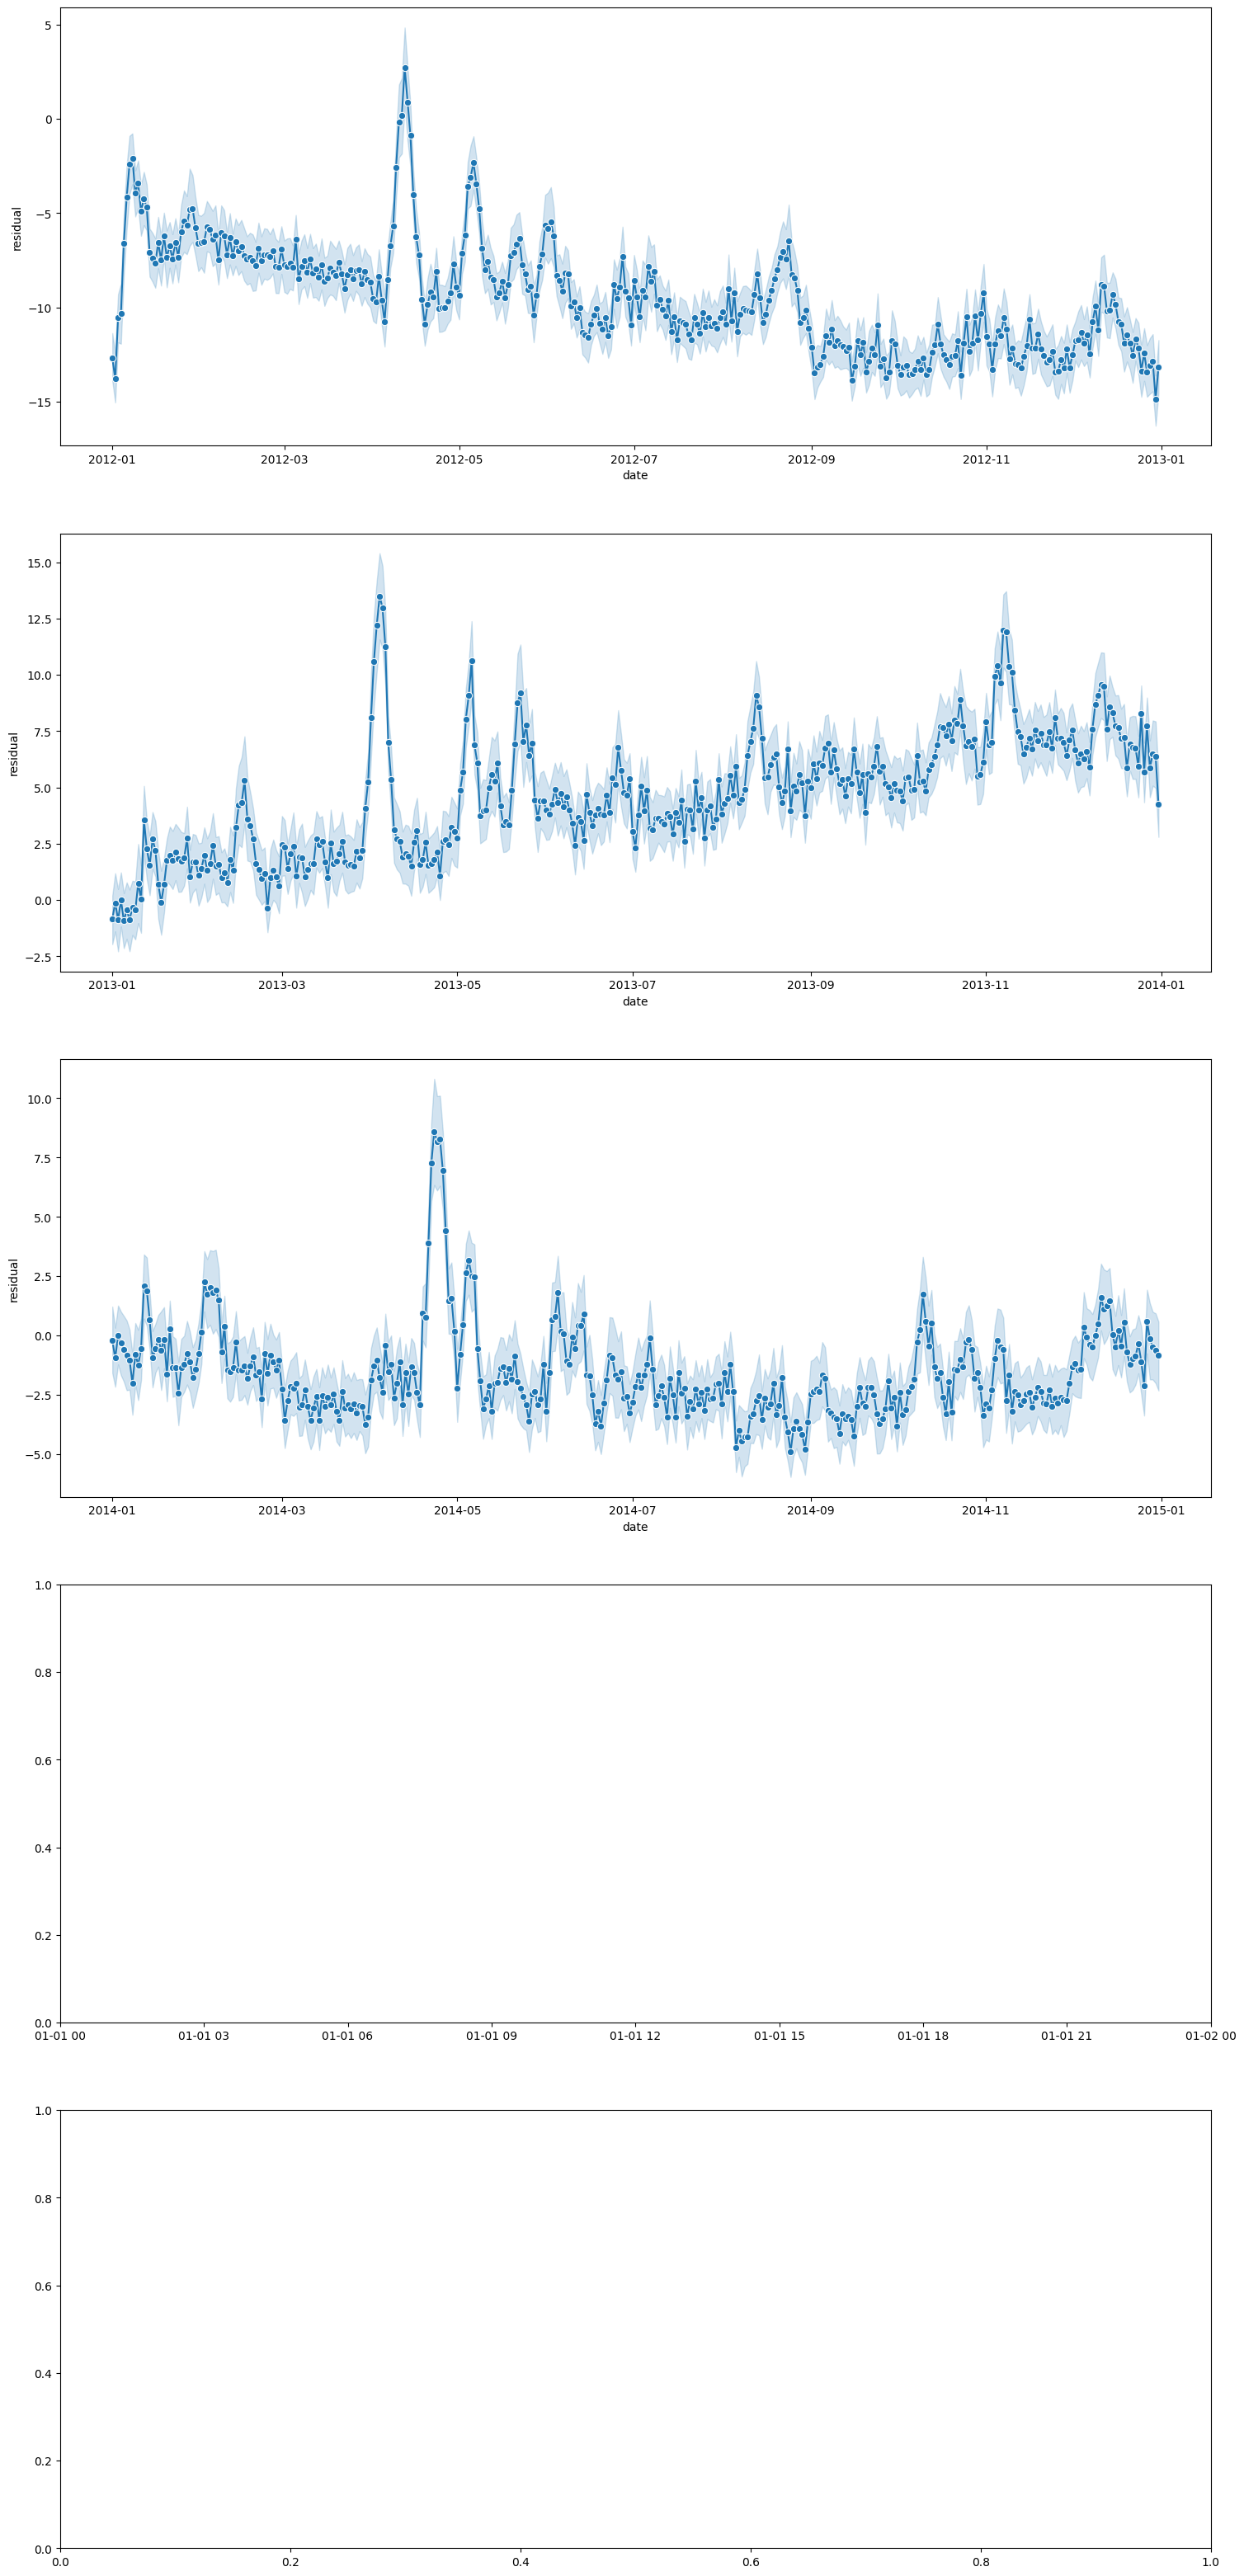

In [42]:
fig, ax = plt.subplots(5, 1, figsize=(18, 40))

for i in range(5):
    f1 = residuals_df.loc[residuals_df.fold == i + 1]
    sns.lineplot(f1, x='date', y='residual', marker='o', ax=ax[i])
plt.show()
plt.tight_layout()

In [43]:
model = Ridge()

model.fit(X_train_scaled, np.log(y_train).ravel())

test_pred = np.exp(model.predict(X_test_scaled))

# Submission

In [44]:
sample_submission['num_sold'] = np.ceil(test_pred)
sample_submission.head()

,id,num_sold
0,230130,153.0
1,230131,964.0
2,230132,793.0
3,230133,429.0
4,230134,502.0


In [45]:
sample_submission.to_csv('submission.csv', index=False)